In [34]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [35]:
def readData(file_path):
    '''
        This function reads the data from the data text file and converts it into an array of 3-size tuples where first element is the index of the data sample (sample no.),
        second is the relevance score/label and third is the actual data sample. 
    '''
    file = open(file_path, 'r') #open data file
    lines = file.readlines() #read data file
    query_url_pairs = []
    for idx, line in enumerate(lines):
        line_toks = line.split()
        qid = line_toks[1]
        if(qid == 'qid:4'): #select the rows corresponding to qid:4
            query_url_pair_idx = idx
            relevance_label = int(line_toks[0])
            data_row = line
            query_url_pairs.append((query_url_pair_idx, relevance_label, data_row))
    return query_url_pairs

In [36]:
def make_max_dcg_file(query_url_pairs):
    '''
        This function forms the file with the query-url pairs (samples) arrange in the order of max DCG. Returns the file name, 
        the query-url pairs sorted in desending order, number of files having arrange of pairs with max DCG, counts of number of pairs wrt relevance labels

    '''
    #Note the max DCG file will be the file having the query-url pairs sorted in decreasing order of relevance labels
    reverse_sorted_by_relevance = sorted(query_url_pairs, key=lambda x: x[1], reverse=True) #sort the query_url_pairs in descending order of relevance label
    counts_by_relevance_label = {0 : 0, 1 : 0, 2 : 0, 3 : 0, 4 : 0} #maintain the counts wrt each relevance label for tha dataset
    max_dcg_file_lines = [] #just to store the lines to write to file
    for qpr in query_url_pairs:
        counts_by_relevance_label[qpr[1]] += 1
        max_dcg_file_lines.append(qpr[2])
    file_name = "max_dcg_file.txt"
    with open(file_name, 'w') as f:
        f.writelines(max_dcg_file_lines) #write to file
    num_max_dcg_files = 1 #number of max DCG files is equal to product of factorials of the number of samples corresponding to each label
    for lab in counts_by_relevance_label.keys():
        num_max_dcg_files *= math.factorial(counts_by_relevance_label[lab])
    
    return file_name, reverse_sorted_by_relevance, num_max_dcg_files, counts_by_relevance_label

In [37]:
def compute_DCG(qu_pairs_data):
    '''
        Calculate the DCG for a given arrangement of query-url pairs data
    '''
    dcg_value = qu_pairs_data[0][1] #initialize the dcg value with relevance label of the first data sample
    for i in range(1, len(qu_pairs_data)):
        dcg_value += (qu_pairs_data[i][1] / math.log2(i + 1))
    return dcg_value


In [38]:
def compute_nDCG(original_qu_pairs, sorted_qu_pairs, p):
    '''
        Calculate the nDCG for a given arrangement of query-url pairs data. Another input 'p' is for 
    '''
    dcg_p = compute_DCG(original_qu_pairs[:p]) #DCG at p (for the first p samples)
    idcg_p = compute_DCG(sorted_qu_pairs[:p]) #IDCG at p (for the first p samples) which corresponds to effectively the DCG for the arrangement sorted in descending order of the relevance labels i.e the max dcg arrangement
    ncdg_p = dcg_p / idcg_p #formula for ncdg
    return ncdg_p

Part 1,2,3

In [39]:
file_path = "../data/IR-assignment-2-data.txt"
query_url_pairs = readData(file_path) #reading the data
num_data = len(query_url_pairs) #number of samples (query-url pairs)
max_dcg_file_name, sorted_qu_pairs, num_max_dcg_files, counts_labels = make_max_dcg_file(query_url_pairs)
print(f"Counts wrt labels: {counts_labels}")
print(f"No. of max DCG files : {num_max_dcg_files}\n")
p_values = [50, num_data]
for p in p_values:
    nDCG_p = compute_nDCG(query_url_pairs, sorted_qu_pairs, p)
    print(f"nDCG at {p if p==50 else 'whole dataset'} : {nDCG_p}")

Counts wrt labels: {0: 59, 1: 26, 2: 17, 3: 1, 4: 0}
No. of max DCG files : 19893497375938370599826047614905329896936840170566570588205180312704857992695193482412686565431050240000000000000000000000

nDCG at 50 : 0.3521042740324887
nDCG at whole dataset : 0.5979226516897831


Part 4

In [40]:
qu_pairs_with_tf_idf_sum = [] #stores the query-url pair samples just as the previously stored pairs, just the value of feature 75 is also added to each 3 size tuple making it now 4-size tuple each
for qu_pair in query_url_pairs:
    sum_tf_idf_doc = float(qu_pair[2].split()[76].split(':')[1]) #extracting value of feature 75
    qu_pairs_with_tf_idf_sum.append((qu_pair[0], qu_pair[1], sum_tf_idf_doc, qu_pair[2]))


In [41]:
ranked_qu_pairs = sorted(qu_pairs_with_tf_idf_sum, key=lambda x : x[2], reverse=True) #ranking based on value of feature 75 (sorted in descending order based on value of feature 75)

In [42]:
precision_k = [] #precision values
recall_k = [] #recall values
relevant_at_k = 0 #number of relevant URL at 'k'
total_relevant = 0 #total number of relevant URLs overall
for rqpr in ranked_qu_pairs:
    if(rqpr[1] != 0): #non-zero relevance judgement value means a relevant URL
        total_relevant += 1
for i in range(len(ranked_qu_pairs)):
    if(ranked_qu_pairs[i][1] != 0): #if relevance judgement value is non-zero i.e doc is relevant 
        relevant_at_k += 1 #increment the value of relevant URLs till k by one
    p_k = relevant_at_k / (i + 1) #precision formula [i+1 -> total URLs till now, relevant_at_k -> relevant URLs till now]
    r_k = relevant_at_k / total_relevant #recall formula
    precision_k.append(p_k)
    recall_k.append(r_k)

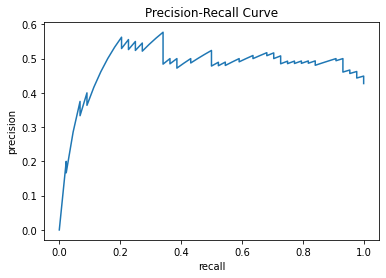

In [43]:
#plotting code
plt.plot(recall_k, precision_k)
plt.ylabel("precision")
plt.xlabel("recall")
plt.title("Precision-Recall Curve")
plt.savefig('Precision_Recall_Curve.png', bbox_inches='tight', facecolor='white')
plt.show()
